In [1]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Name: Tesla T4


In [2]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!pip install opendatasets


In [6]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: reemramadannegm
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


In [7]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [8]:
train_data_dir = '/content/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data

,filepaths,labels
0,/content/brain-tumor-mri-dataset/Training/notu...,notumor
1,/content/brain-tumor-mri-dataset/Training/notu...,notumor
2,/content/brain-tumor-mri-dataset/Training/notu...,notumor
3,/content/brain-tumor-mri-dataset/Training/notu...,notumor
4,/content/brain-tumor-mri-dataset/Training/notu...,notumor
...,...,...
5707,/content/brain-tumor-mri-dataset/Training/pitu...,pituitary
5708,/content/brain-tumor-mri-dataset/Training/pitu...,pituitary
5709,/content/brain-tumor-mri-dataset/Training/pitu...,pituitary
5710,/content/brain-tumor-mri-dataset/Training/pitu...,pituitary


In [9]:
test_data_dir = '/content/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt

,filepaths,labels
0,/content/brain-tumor-mri-dataset/Testing/notum...,notumor
1,/content/brain-tumor-mri-dataset/Testing/notum...,notumor
2,/content/brain-tumor-mri-dataset/Testing/notum...,notumor
3,/content/brain-tumor-mri-dataset/Testing/notum...,notumor
4,/content/brain-tumor-mri-dataset/Testing/notum...,notumor
...,...,...
1306,/content/brain-tumor-mri-dataset/Testing/pitui...,pituitary
1307,/content/brain-tumor-mri-dataset/Testing/pitui...,pituitary
1308,/content/brain-tumor-mri-dataset/Testing/pitui...,pituitary
1309,/content/brain-tumor-mri-dataset/Testing/pitui...,pituitary


In [10]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [25]:
batch_size=16
img_size = (240,240)
channels = 3
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


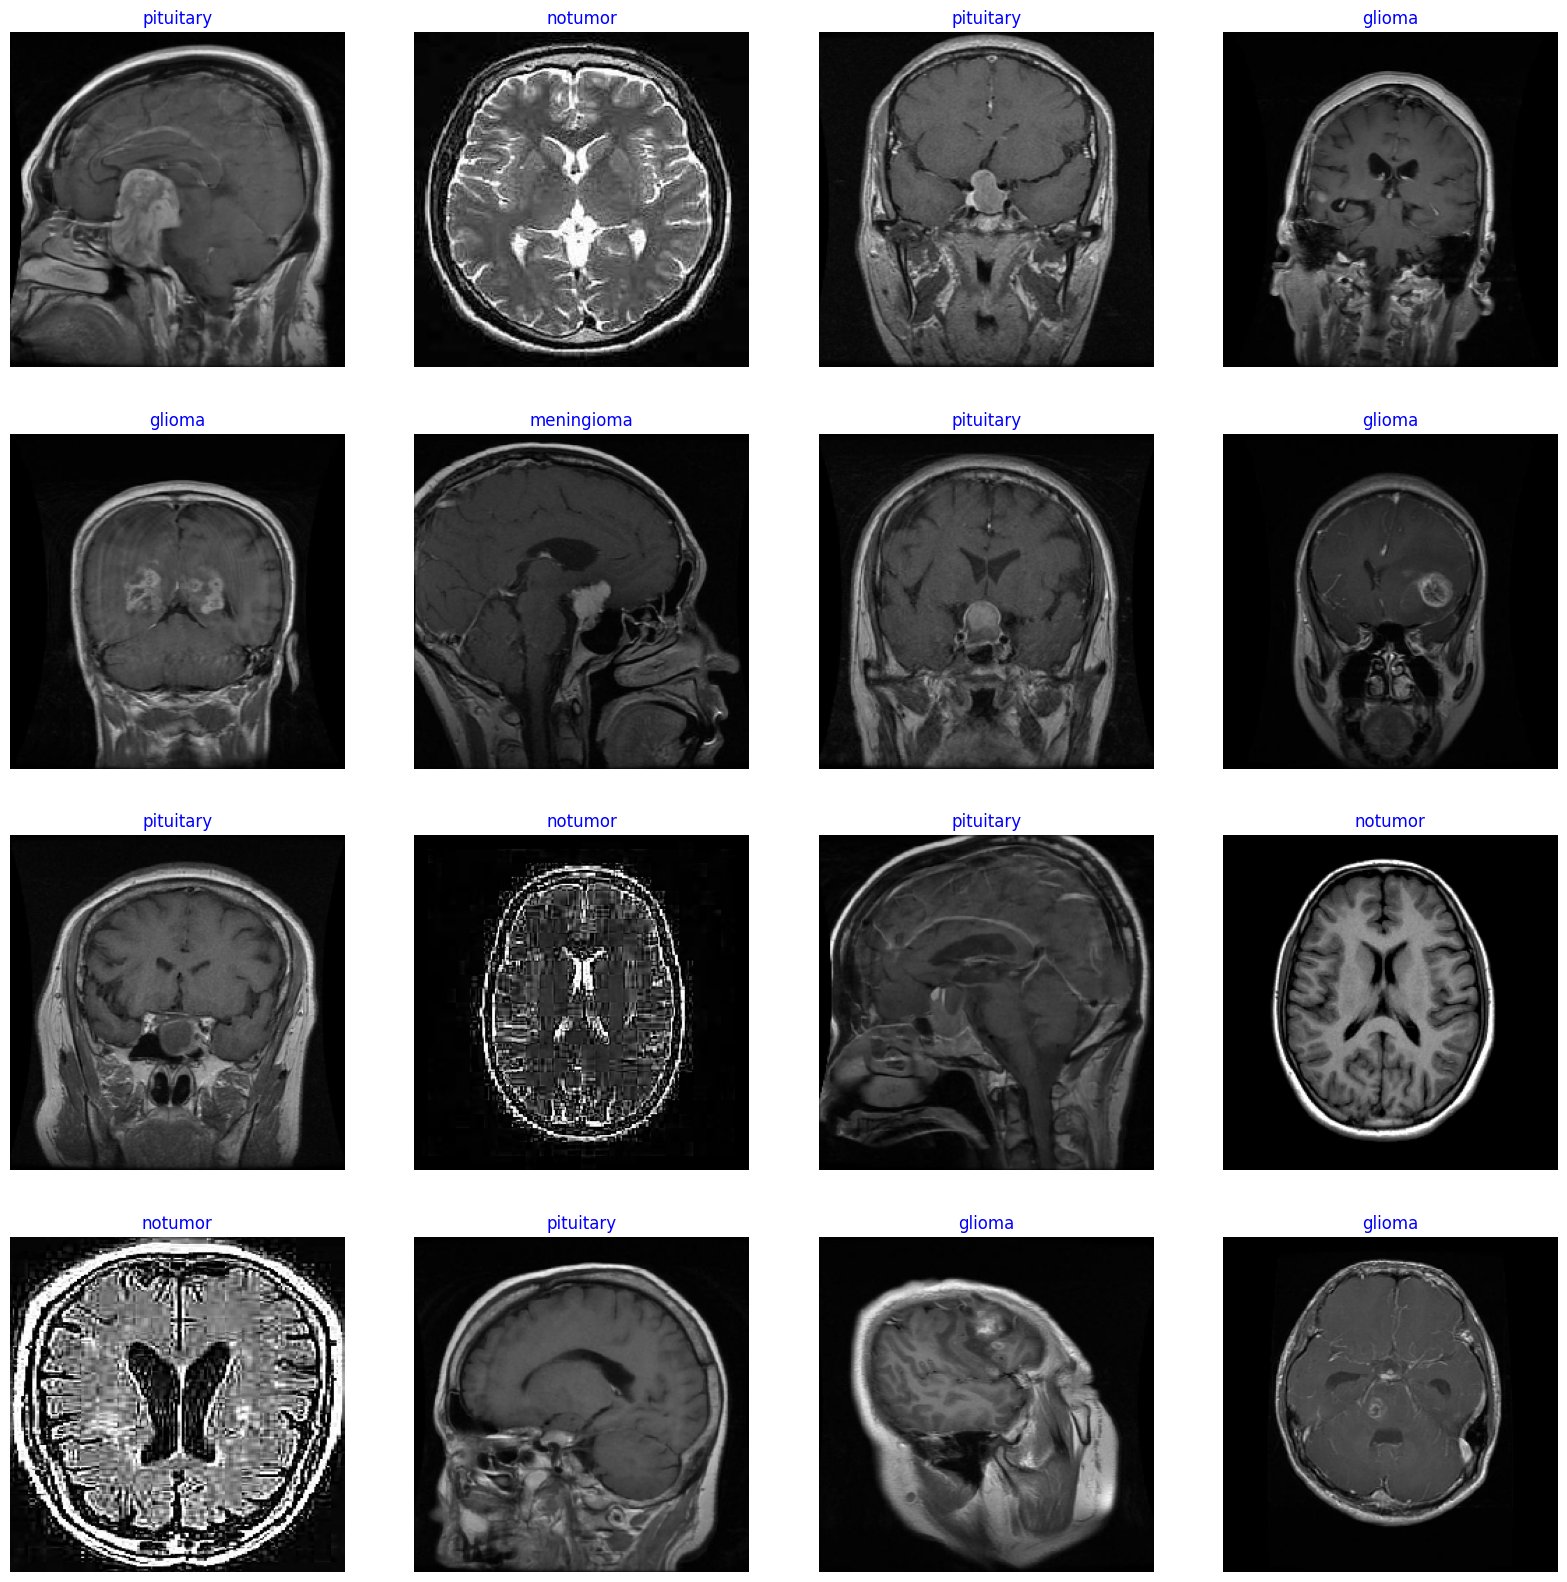

In [26]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

In [27]:
img_size = (240, 240)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 1280)           │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,909,323 (26.36 MB)

 Trainable params: 6,844,708 (26.11 MB)

 Non-trainable params: 64,615 (252.41 KB)

In [28]:
epochs = 15
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 161s 163ms/step - accuracy: 0.4618 - loss: 9.9014 - val_accuracy: 0.3191 - val_loss: 5.8123
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.3235 - loss: 5.1838 - val_accuracy: 0.3053 - val_loss: 3.9654
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - accuracy: 0.2959 - loss: 3.6138 - val_accuracy: 0.2916 - val_loss: 2.8896
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.2949 - loss: 2.6036 - val_accuracy: 0.2947 - val_loss: 2.2072
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.2890 - loss: 2.0466 - val_accuracy: 0.2840 - val_loss: 1.8073
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.2755 - loss: 1.7362 - val_accuracy: 0.2779 - val_loss: 1.6018
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.2851 - loss: 1.5747 - val_accuracy: 0.2779 - val_loss: 1.5102
Epoch 8/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 44s 122ms/step - accuracy: 0.4249 - loss: 

In [30]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9945 - loss: 0.4156
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9941 - loss: 0.4296
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9792 - loss: 0.4406


In [31]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [32]:
# Added part to print classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Compute and print accuracy, precision, recall, F1-score
accuracy = accuracy_score(test_gen.classes, y_pred)
precision = precision_score(test_gen.classes, y_pred, average='weighted')
recall = recall_score(test_gen.classes, y_pred, average='weighted')
f1 = f1_score(test_gen.classes, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9787
Precision: 0.9787
Recall: 0.9787
F1 Score: 0.9786
